# Подготовка данных и тренировка сети

## Распоковка архива с данными

In [2]:
!tar -xf internship_data.tar.gz 

## Импорт необходимых библиотек

In [1]:
import numpy as np
import torch
import time
import os

from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2
from torchvision import transforms
from torch import nn
import random
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt

import torch.nn as nn
import numpy as np
import torch

import torch 
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import cosine
from sklearn import metrics


RANDOM_SEED=13
CUDN_DETERMENISTIC=True
NUM_CLASSES=2


## Фиксируем случайные значения для воспроизводимости результатов

In [2]:
def fix_random_seed(seed, cudnn_determenistic=False):
    random.seed(seed);
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=cudnn_determenistic

In [3]:
fix_random_seed(RANDOM_SEED,CUDN_DETERMENISTIC)

## Необходимые функции для разбиения набора данных на тестовую и тренировочную выборку. А также функции для преобразования данных (аугментация, нормализация, изменение размера изображения), для корректной подачи вход нейросети и улучшения качества тренировки.

In [4]:
import numpy as np
import os

from torch.utils.data import Dataset
from torch.utils.data import Sampler
from torchvision.datasets import ImageFolder


class AllCropsDataset(Dataset):
    def __init__(self, image_folder, subset='', transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        # data subset (train, test)
        self.subset = subset
        # store each crop data
        self.datasets = []
        self.crops = []
        self.samples = []
        self.imgs = []
        self.classes = []
        self.targets = []
        self.class_to_idx = {}
        # iterate over all folders 
        # with all crops
        for i, d in enumerate(os.listdir(image_folder)):
            self.crops.append(d)
            # full path to the folder
            d_path = os.path.join(image_folder, d, self.subset)
            # attribute name to set attribute 
            attr_name = '%s_ds' % d.lower()
            print("Load '%s' data" % attr_name)
            # set the attribute with the specified name
            setattr(self, attr_name, ImageFolder(d_path))
            # add the dataset to datasets list
            self.datasets.append(getattr(self, attr_name))
            # get dataset attribute
            ds = getattr(self, attr_name)
            # add attr targets to the global targets
            ds_targets = [x+len(self.classes) for x in ds.targets]
            self.targets.extend(ds_targets)
            # add particular classes to the global classes' list
            ds_classes = []
            for c in ds.classes:
                new_class = '__'.join([d, c])
                self.class_to_idx[new_class] = len(self.classes) + ds.class_to_idx[c]
                ds_classes.append(new_class)
            self.classes.extend(ds_classes)
            # imgs attribute has form (file_path, target)
            ds_imgs, _ = zip(*ds.imgs)
            # images and samples are equal
            self.imgs.extend(list(zip(ds_imgs, ds_targets)))
            self.samples.extend(list(zip(ds_imgs, ds_targets)))
            
            
    def __len__(self):
        return len(self.samples)
      
      
    def __getitem__(self, idx):
        path, target = self.samples[idx]
        img = self.datasets[0].loader(path)
        
        if self.transform is not None:
            img = self.transform(img)
        
        if self.target_transform is not None:
            target = self.target_transform(target)
            
        return img, target

In [5]:
DATA_PATH = 'internship_data'

def prepare_datasets():
    train_ds = AllCropsDataset(
        DATA_PATH, 
        subset='train',
        transform=transforms.Compose([
            transforms.RandomResizedCrop(224),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            # transforms.Normalize([0.4352, 0.5103, 0.2836], [0.2193, 0.2073, 0.2047])]),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
          target_transform=torch.tensor)

    test_ds = AllCropsDataset(
        DATA_PATH, 
        subset='test',
        transform=transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        target_transform=torch.tensor)

    # print statistics
    print('Train size:', len(train_ds))
    print('Test size:', len(test_ds))
    print('Number of samples in the dataset:', len(train_ds))
    print('Crops in the dataset:', train_ds.crops)
    print('Total number of classes in the dataset:', len(train_ds.classes))
    print('Classes with the corresponding targets:')
    print(train_ds.class_to_idx)
    return train_ds, test_ds

In [6]:
import numpy as np
import shutil
import os

from glob import glob
from tqdm import tqdm
from tqdm.notebook import tqdm

TEST_SIZE = 0.2
RS = 42
def _remove_path_if_exists(path):
    if os.path.exists(path):
        if os.path.isfile(path):
            os.remove(path)
        else:
            shutil.rmtree(path)

def _makedir_and_copy2(path, dirname, fnames):
    path_for_saving_files = os.path.join(path, dirname)
    os.makedirs(path_for_saving_files)

    for fname in fnames:
        shutil.copy2(fname, path_for_saving_files)

def datadir_train_test_split(origin_path, test_size, random_state=0):
    """Splits the data in directory on train and test.
    # Arguments
        origin_path: path to the original directory
        test_size: the size of test data fraction
    # Returns
        Tuple of paths: `(train_path, test_path)`.
    """
    print("\n\nSplit `%s` directory" % origin_path)
    print("Test size: %.2f" % test_size)
    print("Random state: {}".format(random_state))
    train_path = os.path.join(origin_path, 'train')
    test_path = os.path.join(origin_path, 'test')   
    _remove_path_if_exists(train_path)
    _remove_path_if_exists(test_path)
    print ("1")
    try:
       
        subfolders = glob(os.path.join(origin_path, ""))
        
        # if train/test split is already done
        if set(subfolders) == set(['train', 'test']):
            print("4")
            return (train_path, test_path)
       
        # if train/test split is required
        # recreate train/test folders
        os.makedirs(train_path)
        os.makedirs(test_path)
        print(subfolders)

        for folder in tqdm(subfolders, total=len(subfolders), ncols=57):
            print("2")
            # collect all images
            img_fnames = []
            for ext in ["*.jpg", "*.png", "*jpeg"]:
                img_fnames.extend(
                    glob(os.path.join(folder, ext)))
            # set random state parameter
            rs = np.random.RandomState(random_state)
            # shuffle array
            rs.shuffle(img_fnames)
            # split on train and test
            n_test_files = int(len(img_fnames)*test_size)
            test_img_fnames = img_fnames[:n_test_files]
            train_img_fnames = img_fnames[n_test_files:]
            # copy train files into `train_path/folder`
            folder_name = os.path.basename(os.path.dirname(folder))
            _makedir_and_copy2(train_path, folder_name, train_img_fnames)
            # copy test files into `test_path/folder`
            _makedir_and_copy2(test_path, folder_name, test_img_fnames)
        for file in os.listdir(subfolders[0]):
          if file.endswith('.jpg'):
            os.remove(os.path.join(subfolders[0], file))
        for file in os.listdir(subfolders[0]):
          if file.endswith('.jpg'):
            os.remove(os.path.join(subfolders[0], file))
        

    except:
        print("3")
        _remove_path_if_exists(train_path)
        _remove_path_if_exists(test_path)
        raise 
        
    return (train_path, test_path)

In [7]:
def split_on_train_and_test(random_seed):
    for crop in os.listdir('internship_data'):
        crop_path = os.path.join('internship_data', crop)
        _ = datadir_train_test_split(crop_path, 
                                    test_size=0.2, 
                                    random_state=random_seed)

# Разбиение данных на тестовые и тренировочные

In [10]:
split_on_train_and_test(RANDOM_SEED)



Split `internship_data/male` directory
Test size: 0.20
Random state: 13
1
['internship_data/male/']


2



Split `internship_data/female` directory
Test size: 0.20
Random state: 13
1
['internship_data/female/']


2



## Подготовка данных на вход сети

In [8]:
train_ds, test_ds = prepare_datasets()

Load 'female_ds' data
Load 'male_ds' data
Load 'female_ds' data
Load 'male_ds' data
Train size: 80002
Test size: 20000
Number of samples in the dataset: 80002
Crops in the dataset: ['female', 'male']
Total number of classes in the dataset: 2
Classes with the corresponding targets:
{'female__female': 0, 'male__male': 1}


## Пример изображения в тренировочном датасете

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


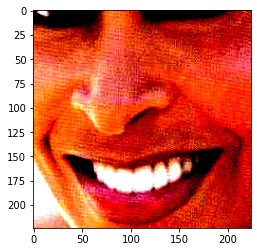

In [9]:
plt.imshow(train_ds[16][0].permute(1,2,0))


## Так как в исходном наборе данных мы работаем с лицами, то целесообразно будет взять в качестве базовой модели модель предобученную на лицах. И доучить ее на изображениях из нашего набора данных

In [10]:
 !pip install facenet-pytorch

Defaulting to user installation because normal site-packages is not writeable


## Инициализируем модель  InceptionResnetV1 предобученную на изображениях лиц людей, значения параметра num_classes это количество классов в нашем датасете (у нас их два мужчины и женщины)

In [12]:
from facenet_pytorch import InceptionResnetV1
model = InceptionResnetV1(pretrained='vggface2',num_classes=2,classify=True).eval()

## Загрузим наборы данных в тренировочные и тестовый dataloader

In [13]:
batch_size = 256
train_dataloader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
dataloaders=train_dataloader
val_dataloader=torch.utils.data.DataLoader(
    test_ds, batch_size=batch_size, shuffle=True, num_workers=2)

## Чтобы не тренировчный цикл воспользуемся готовой библиотекой для тренировки сетей на фреймворке Pytorch: torchbearer ( если библиотека отсутсвует нужно ее установить):

```console
pip install torchbearer
```
## Также укажем необохдимые колбеки, мы будем сохранять лучшую модель по критерию accuracy на тестовой выборке, в качестве оптимизатора выберем Adam c параметром learning rate = 0.0001, в качестве функции ошибки возьмем кросс энтропию (потому что у нас задача классификации), и метрики по которым мы будем следить за тренировкой это accuracy и loss

In [14]:
!pip install torchbearer

Defaulting to user installation because normal site-packages is not writeable


In [15]:
from torchbearer import Trial
import torch
from torchbearer.callbacks import Best
from torch.optim import Adam
checkpoint = Best(
        'classifier.pt',  
        monitor='val_acc',
        mode='max',
        save_model_params_only=True)
trial = Trial(model, callbacks=[checkpoint], optimizer=Adam(model.parameters(), lr = 0.0001), criterion=torch.nn.CrossEntropyLoss(reduction='sum'), metrics=['acc', 'loss'])

## Процесс тренировки сети на GPU ( сеть обучалась 40 эпох на видеокарте Tesla V100-SXM2 ресурс предоставлен JINR (jhub2.jinr.ru) )

In [16]:
trial.with_train_generator(train_dataloader).with_val_generator(val_dataloader)
trial.to('cuda')
feature_extractor_hist = trial.run(40)

KeyboardInterrupt: 

## Accuracy модели в репозитории равна 96,5% на тестовой выборке